## _*Variational Quantum Classifier*_

The QSVM notebook demonstrates a kernel based approach. This notebook shows a variational method.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import StatevectorSampler


from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.optimizers import SPSA

First we prepare the dataset, which is used for training, testing and the finally prediction.

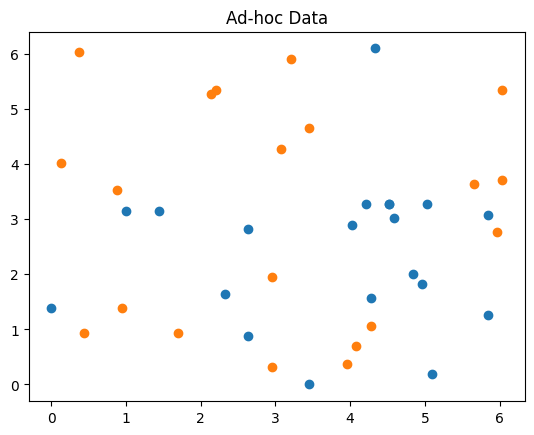

In [2]:
feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

train_data, train_labels, test_data, test_labels = ad_hoc_data(
    training_size=training_dataset_size,
    test_size=testing_dataset_size,
    n=feature_dim,
    gap=0.3,
    plot_data=True,
    one_hot=False
    )

The quantum circuit is made of:
- an encoder (here the ZZFeatureMap is used); x[0] and x[1] are the features of the data point
- a variational form (TwoLocal, probably the simplest there is); the parameters are those learned by the optimizer

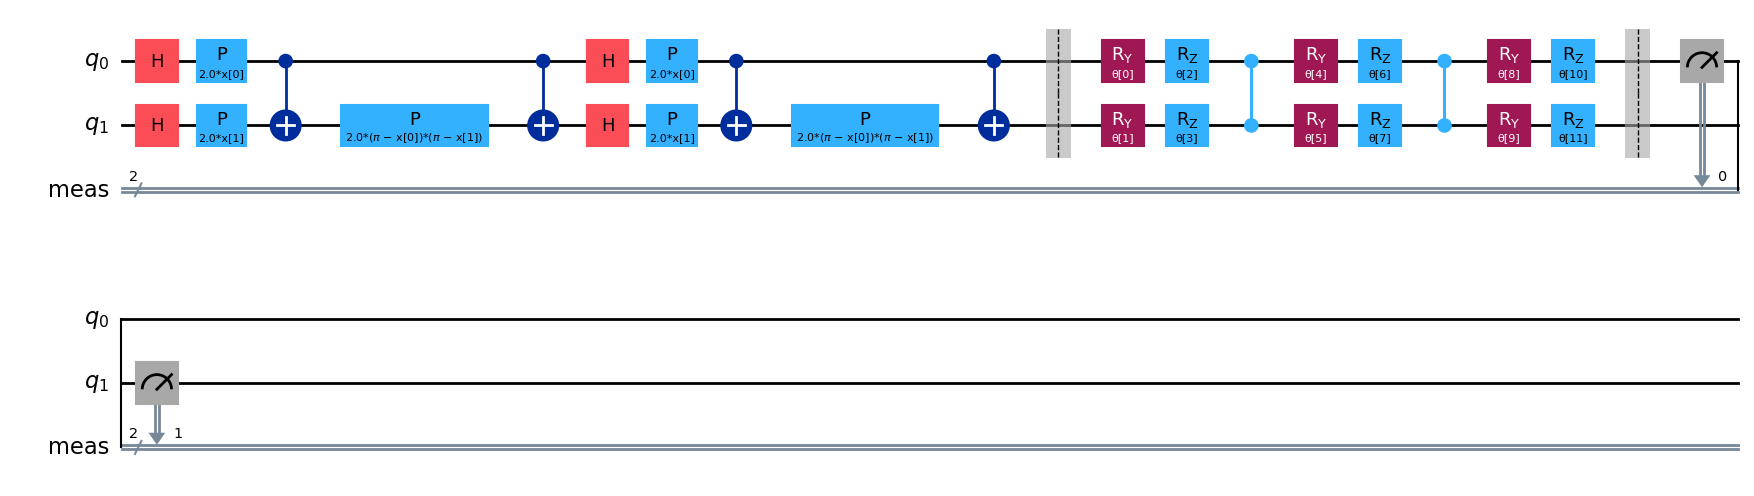

In [3]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
feature_map.barrier()
var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

ad_hoc_circuit = feature_map.compose(var_form)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

In [4]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)


def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2


def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)


def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost


def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)

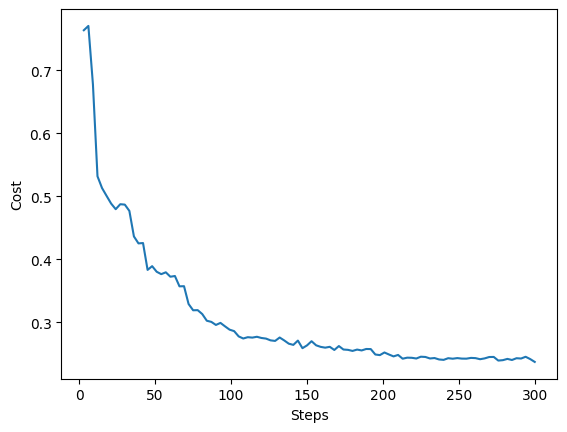

In [5]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [6]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0

    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(test_data, test_labels, opt_var)
accuracy

1.0

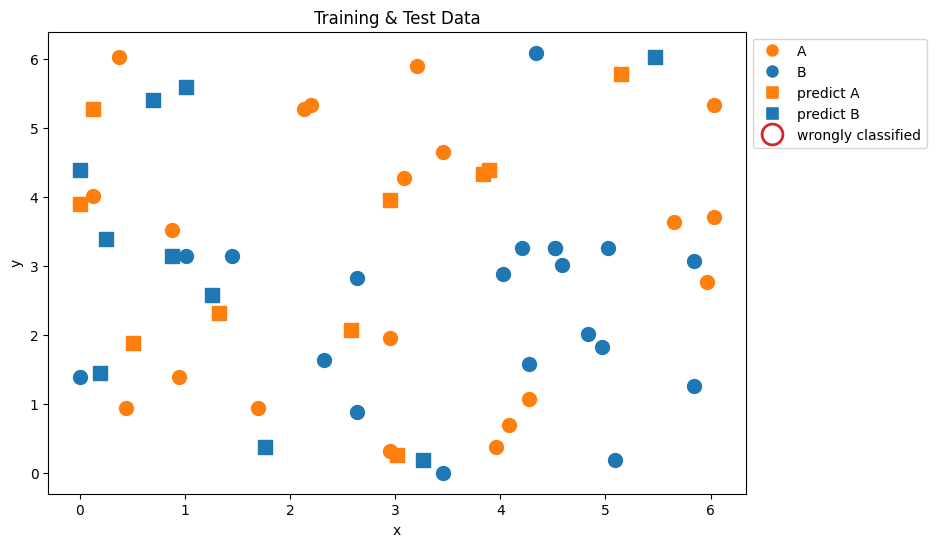

In [7]:
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(test_data, test_labels, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()